### Import the needed Modules

In [95]:
# from models import *
%matplotlib ipympl
from impedance.models.circuits.elements import element
from impedance.preprocessing import readCSV, readBioLogic
from impedance.visualization import plot_nyquist,plot_bode
from impedance.models.circuits import CustomCircuit
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from arbitau import give_z_for_arbitary_tau, tau_plotter
from scipy.integrate import solve_bvp

### Generate the Impedance Data

In [117]:
freq_to_fit=np.logspace(-1,2,100)
#parameter for the TLM
Q=1e-6
alpha=1

R1=400
delta1=0.1
R2=400
delta2=0.3
R3=400


#initial guesses for the HFR intercept and for any semicircle like features in the EIS data
Rhfr=40
Rrxn=40
Qdl=1e-6
alpha2=1

#For Two-step provide R1,R2,Q,delta1,alpha
#For Three-step provide R1,R2,R3,Q,delta1,delta2,alpha
#For Linear provide R1,R2,Q,alpha
#For Inv-Linear provide R1,R2,Q,alpha


#---uncomment the line below for fitting the uniform tortuosity profile---

#for uniform tortuosity
#cmodel=CustomCircuit(initial_guess=[R1,Q,alpha,Rhfr,Rrxn,Qdl,alpha2],circuit="TLMuni_1-R_1-p(R_2,CPE_1)")

#for two-step tortuosity
#cmodel=CustomCircuit(initial_guess=[R1,R1*Q,R2*Q,delta1,alpha,Rhfr,Rrxn,Qdl,alpha2],circuit="TLMtwo_1-R_1-p(R_2,CPE_1)")

#for three-step tortuosity 
cmodel_for_data=CustomCircuit(initial_guess=[R1,R1*Q,R2*Q,R3*Q,delta1,delta2,alpha,Rhfr,Rrxn,Qdl,alpha2],circuit="TLMthree_1-R_1-p(R_2,CPE_1)")

#for linear tortuosity
# cmodel=CustomCircuit(initial_guess=[R1,R1*Q,R2*Q,alpha,Rhfr,Rrxn,Qdl,alpha2],circuit="TLMlin_1-R_1-p(R_2,CPE_1)")

#for inverse-linear tortuosity
# cmodel=CustomCircuit(initial_guess=[R1,R1*Q,R2*Q,alpha,Rhfr,Rrxn,Qdl,alpha2],circuit="TLMilin_1-R_1-p(R_2,CPE_1)")

zexp_to_fit=cmodel_for_data.predict(frequencies=freq_to_fit)
# print(zexp_to_fit)

### See the Input Synthetic Data

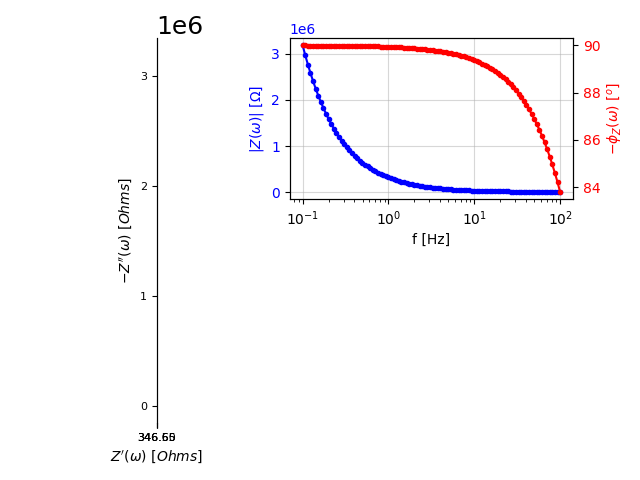

In [118]:
##-----------##
#put the nyquist and the bode plot on the same figure

fig= plt.figure()
ax_nyq=fig.add_subplot(121)
ax_mag=fig.add_subplot(222)
ax_phs=ax_mag.twinx()

#plot nyquist plot of the taken data
plot_nyquist(zexp_to_fit,ax=ax_nyq,labelsize=10,ticksize=8)

#plot bode plot of the taken data
mag_color="blue"
phs_color="red"
ax_mag.plot(freq_to_fit, np.abs(zexp_to_fit), '.-', color=mag_color)
ax_phs.plot(freq_to_fit, -np.angle(zexp_to_fit, deg=True), '.-',color=phs_color)
ax_mag.set_ylabel(r'$|Z(\omega)|$ ' +'$[{}]$'.format("Ω"), fontsize=10,color=mag_color)
ax_phs.set_ylabel(r'$-\phi_Z(\omega)$ ' + r'$[^o]$', fontsize=10,color=phs_color)
ax_mag.set_xlabel('f [Hz]', fontsize=10)
ax_mag.set_xscale('log')
ax_mag.tick_params(axis='y', labelcolor=mag_color)
ax_phs.tick_params(axis='y', labelcolor=phs_color)
ax_mag.grid(visible=True, which='major', axis='both', alpha=.5)
fig.tight_layout()

### The numerical BVP solving for Arbitary profile 

In [121]:
@element(num_params=4,units=["","","","",""],overwrite=True)
def arbitRCPE(p,f):
    # modify the number of parameters according to the torutosity function
    Q, alpha, a, b = p[0], p[1], p[2], p[3]

    #we want to give only R1 and R2 and one two more parameters
    # provide the definition for the arbitrary tortuosity function
    
    def R(x):
        # return 5+np.tanh(x*10-3)+2*np.tanh(x*10-5)
        return a*x+b
    
    def fun(x,y,lmdcos,lmdsin):
        return np.vstack((y[2]*R(x),y[3]*R(x),lmdcos*y[0]-lmdsin*y[1],lmdcos*y[1]+lmdsin*y[0]))

    def bc(ya,yb):
        return np.array([ya[0]-1,yb[2],yb[3],ya[1]])

    x=np.linspace(0,1,1000)
    y=np.zeros((4,x.size))
 
    Z_list=np.zeros((np.size(np.array(f))),dtype=complex)
    ii=0
    for freq in np.array(f):
        w=2*np.pi*freq
        lmdcos=w**alpha*Q*(alpha*np.pi/2)
        lmdsin=w**alpha*Q*np.sin(alpha*np.pi/2)
        sol1 = solve_bvp(lambda x,y: fun(x,y,lmdcos=lmdcos,lmdsin=lmdsin), bc, x, y)
        y3=sol1.sol(x)[2]
        y4=sol1.sol(x)[3]
        Z=2/(-(y3[0]+y4[0]*1j))
        Z_list[ii]=Z
        ii=ii+1

    return Z_list


In [123]:
Q=6.61e-4
a=1
b=3
cmodel_to_fit=CustomCircuit(initial_guess=[Q,1,a,b,Rhfr,Rrxn,Qdl,alpha2],circuit="arbitRCPE_1-R_1-p(R_2,CPE_1)")


#wt="unit"
wt="mod"
#wt="prop"

def give_weights(z,wt):
    if (wt=="mod"):
        return np.concatenate((np.abs(z),np.abs(z)))
    elif (wt=="prop"):
        return np.concatenate((np.real(z),np.imag(z)))
    elif (wt=="" or wt=="unit"):
        return np.ones(2*len(z))
    

##Three Step Fitting
cmodel_to_fit.fit(impedance=zexp_to_fit,frequencies=freq_to_fit,sigma=give_weights(zexp_to_fit,wt),bounds=[(0,0.5,0,0,0,0,0,0.5),(1,1,np.inf,np.inf,np.inf,np.inf,np.inf,1)])

In [101]:
print(cmodel_to_fit)


Circuit string: arbitRCPE_1-R_1-p(R_2,CPE_1)
Fit: True

Initial guesses:
  arbitRCPE_1_0 = 6.61e-04 []
  arbitRCPE_1_1 = 1.00e+00 []
  arbitRCPE_1_2 = 1.00e+02 []
  arbitRCPE_1_3 = 3.00e+00 []
    R_1 = 4.00e+01 [Ohm]
    R_2 = 4.00e+01 [Ohm]
  CPE_1_0 = 1.00e-06 [Ohm^-1 sec^a]
  CPE_1_1 = 1.00e+00 []

Fit parameters:
  arbitRCPE_1_0 = 9.95e-07  (+/- 3.15e-07) []
  arbitRCPE_1_1 = 9.98e-01  (+/- 1.47e-01) []
  arbitRCPE_1_2 = 1.00e+02  (+/- 4.52e+03) []
  arbitRCPE_1_3 = 3.00e+00  (+/- 9.93e+01) []
    R_1 = 4.00e+01  (+/- 6.29e+03) [Ohm]
    R_2 = 4.00e+01  (+/- 4.14e+04) [Ohm]
  CPE_1_0 = 1.39e-03  (+/- 1.40e+00) [Ohm^-1 sec^a]
  CPE_1_1 = 1.00e+00  (+/- 2.40e+02) []



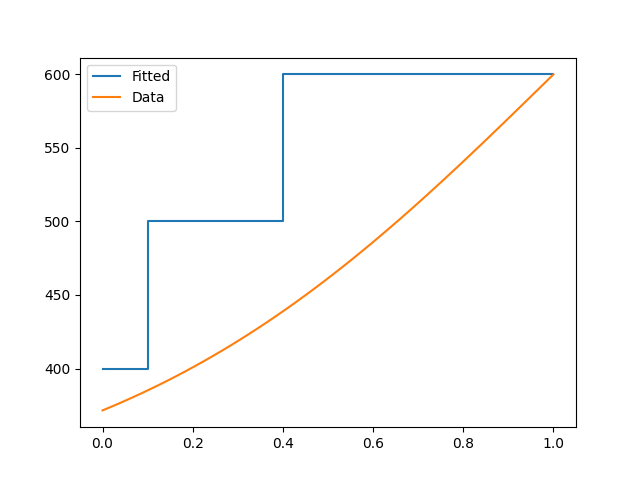

In [102]:
pps=cmodel_to_fit.parameters_
def R_with_x(x,a,b):
        # return 5+np.tanh(x*10-3)+2*np.tanh(x*10-5)
        return a*(b+np.tanh(x-1))

fig, ax =plt.subplots()
xx=np.linspace(0,1)
# R_fitted=R_with_x(xx,pps[2],pps[3])
R_fitted=R_with_x(xx,300,2)
# R_data=R_with_x(xx,a=5,b=3)


#parameter for the TLM
Q=1e-6
alpha=1

R1=400
delta1=0.1
R2=500
delta2=0.3
R3=600

ax.plot([0,delta1,delta1,delta2+delta1,delta2+delta1,1],[R1,R1,R2,R2,R3,R3])
ax.plot(xx,R_fitted)
ax.legend(["Fitted","Data"])

In [103]:
x23=np.linspace(-1,2,100)
plt.plot(x23,1+np.tanh(x23-1))